In [1]:
import numpy as np
import networkx as nx
from collections import defaultdict
from itertools import permutations
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from hmmlearn import hmm
import pandas as pd


C:\Users\Prithvi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [2]:
guide_df = pd.read_csv("Indel\GUIDE-Seq.csv")
circle_df = pd.read_csv("Indel\CIRCLE_seq.csv")


In [3]:
# 1. Hidden Markov Model (HMM) for CRISPR-Cas9 Binding
# Define a simple HMM with two states: Binding (1) and Non-Binding (0)

model = hmm.MultinomialHMM(n_components=2, n_iter=100)
X = np.random.randint(0, 4, (min(1000, len(guide_df)), 1))  # Random sequence data (max 1000 values)
model.fit(X)  # Train the model
Z = model.predict(X)  # Predict binding sites
print("HMM Predicted Binding Sites:", Z)

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


HMM Predicted Binding Sites: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

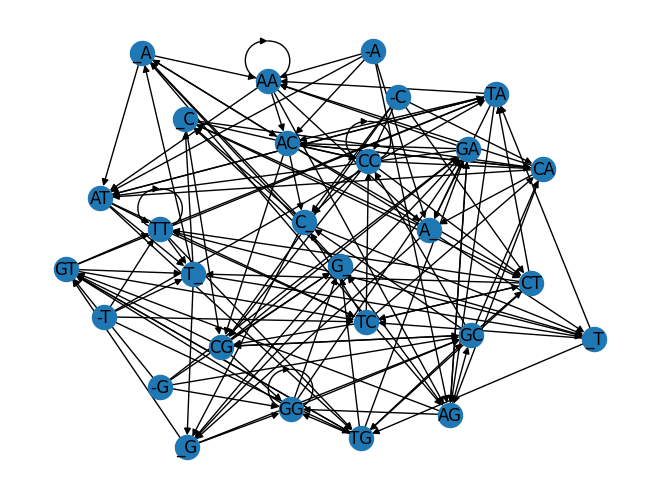

In [4]:
# 2. De Bruijn Graphs for Genome Assembly
def de_bruijn_graph(sequences, k=3):
    graph = nx.DiGraph()
    for seq in sequences:
        for i in range(len(seq) - k + 1):
            kmer1, kmer2 = seq[i:i+k-1], seq[i+1:i+k]
            graph.add_edge(kmer1, kmer2)
    return graph

de_bruijn = de_bruijn_graph(guide_df["DNA"].dropna().sample(n=min(1000, len(guide_df)), random_state=42).tolist())
nx.draw(de_bruijn, with_labels=True)


In [5]:
# 3. Needleman-Wunsch Algorithm (Global Alignment)
def needleman_wunsch(seq1, seq2):
    alignments = pairwise2.align.globalxx(seq1, seq2)
    return format_alignment(*alignments[0])

# Use paired sequences from GUIDE and CIRCLE
guide_sequences = guide_df["DNA"].dropna().tolist()
circle_sequences = circle_df["off_seq"].dropna().tolist()

for i in range(min(len(guide_sequences), len(circle_sequences), 10)):
    print(f"Global Alignment for Pair {i+1}:")
    print(needleman_wunsch(guide_sequences[i], circle_sequences[i]))


Global Alignment for Pair 1:
G----C--TGCCAGTA--CAGGCTCCCCCTC--G-
|    |  || ||| |  ||||           | 
GGAGTCCGTG-CAG-AAGCAGG---------AAGC
  Score=13

Global Alignment for Pair 2:
GCT--G-CC-AGTACAG--GCTCCCCCTC-G-----
 |   | || || | ||  |        | |     
-C-AAGTCCGAG-A-AGAAG--------CAGAAAAG
  Score=12

Global Alignment for Pair 3:
T-A---CT-AG-AGTGACAAGTCACAC-AAT---
  |   || || |   | |||  | |  ||    
-GAAGTCTTAGCA---A-AAG--A-A-GAA-AGC
  Score=14

Global Alignment for Pair 4:
-C_TAGA-GT--GAC--A-AGTC-ACAC-AAT---
|    || ||  ||   | ||   | |  ||    
-----GAAGTCCGA-GGAGAG--GA-A-GAA-AGG
  Score=13

Global Alignment for Pair 5:
-ACAG-CG-AGTACA-A-GCTCATCATGA----
 | || || || | | | |   |  | ||    
GA-AGGCGGAG-A-AGAAG---A--A-GAAATT
  Score=15

Global Alignment for Pair 6:
--A-C---AGCGAGTACA--AGCTCATCATGA--
  | |   ||| || | |  ||   |  | |   
GGAGCCTGAGC-AG-A-AGGAG---A--A-G-GG
  Score=14

Global Alignment for Pair 7:
-GC-A-T-CCAGCACAGCT_--GCCA-G--GA-
||  | | |||| | ||     |  | |  || 
-G-GAGTTCCAG-A-AG-

In [6]:
# 4. Smith-Waterman Algorithm (Local Alignment)
def smith_waterman(seq1, seq2):
    alignments = pairwise2.align.localxx(seq1, seq2)
    return format_alignment(*alignments[0])

for i in range(min(len(guide_sequences), len(circle_sequences), 10)):
    print(f"Local Alignment for Pair {i+1}:")
    print(smith_waterman(guide_sequences[i], circle_sequences[i]))


Local Alignment for Pair 1:
1 G----C--TGCCAGTA--CAGGCTCCCCCTC--G
  |    |  || ||| |  ||||           |
1 GGAGTCCGTG-CAG-AAGCAGG---------AAG
  Score=13

Local Alignment for Pair 2:
2 CT--G-CC-AGTACAG--GCTCCCCCTC------G
  |   | || || | ||  |        |      |
1 C-AAGTCCGAG-A-AGAAG--------CAGAAAAG
  Score=12

Local Alignment for Pair 3:
2 A---CT-AG-AGTGACAAGTCACAC-A-A
  |   || || |   | |||  | |  | |
2 AAGTCTTAGCA---A-AAG--A-A-GAAA
  Score=14

Local Alignment for Pair 4:
5 GA-GT--GAC--A-AGTC-ACAC-A-A
  || ||  ||   | ||   | |  | |
1 GAAGTCCGA-GGAGAG--GA-A-GAAA
  Score=13

Local Alignment for Pair 5:
1 ACAG-CG-AGTACA-A-GCTCATCATG--A
  | || || || | | | |   |  | |  |
2 A-AGGCGGAG-A-AGAAG---A--A-GAAA
  Score=15

Local Alignment for Pair 6:
1 A-C---AGCGAGTACA--AGCTCATCAT--G
  | |   ||| || | |  ||   |  |   |
3 AGCCTGAGC-AG-A-AGGAG---A--A-GGG
  Score=14

Local Alignment for Pair 7:
1 GC-A-T-CCAGCACAGCT_--GCCA-G--GA
  |  | | |||| | ||     |  | |  ||
1 G-GAGTTCCAG-A-AG---AAG--AAGAAGA
  Score=15

Local 

Eulerian Path: No Eulerian Path
Hamiltonian Path: No Hamiltonian Path


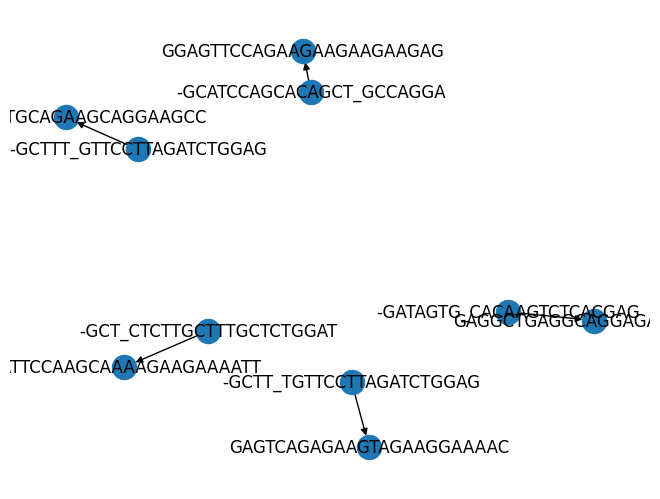

In [7]:
# 5. Overlap Graphs (Hamiltonian & Eulerian Paths)
def construct_overlap_graph(guide_sequences, circle_sequences, k=3):
    graph = nx.DiGraph()
    for guide_seq, circle_seq in zip(guide_sequences, circle_sequences):
        if guide_seq.endswith(circle_seq[:k]):
            graph.add_edge(guide_seq, circle_seq)
    return graph

sequences_sample_size = min(1000, len(guide_sequences), len(circle_sequences))
overlap_graph = construct_overlap_graph(guide_sequences[:sequences_sample_size], circle_sequences[:sequences_sample_size], k=3)
nx.draw(overlap_graph, with_labels=True)

def find_eulerian_path(graph):
    if nx.is_eulerian(graph):
        return list(nx.eulerian_path(graph))
    return "No Eulerian Path"

def find_hamiltonian_path(graph):
    def dfs(path, visited):
        if len(path) == len(graph):
            return path
        last_node = path[-1]
        for neighbor in graph[last_node]:
            if neighbor not in visited:
                result = dfs(path + [neighbor], visited | {neighbor})
                if result:
                    return result
        return None

    for start_node in graph.nodes():
        path = dfs([start_node], {start_node})
        if path:
            return path
    return "No Hamiltonian Path"

print("Eulerian Path:", find_eulerian_path(overlap_graph))
print("Hamiltonian Path:", find_hamiltonian_path(overlap_graph))
